In [1]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np, pandas as pd, scipy
import astropy
from astropy import units as u
import astromet
#from astromet.track import design_matrix, design_1d
#import dev.astromet.astromet as astromet
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import scanninglaw.times
from scanninglaw.source import Source

In [3]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=2
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5

In [4]:
dr3Period=34/12 # in years
mas=astromet.mas # conversion from degrees to milli-arcseconds

# Load in scanning law
- Requires scanninglaw installed
- Takes up a bit of memory (~1Gb I think)

In [5]:
# slooow step - see scanning_law package for details
dr3_sl=scanninglaw.times.Times(version='dr3_nominal')

Loading auxilliary data ...
t = 41.580 s
  auxilliary:  19.282 s
          sf:   7.243 s
interpolator:  15.054 s


# Single source

In [6]:
# System astrometry parameters
params=astromet.params()
params.ra=360*np.random.rand()
params.dec=np.arcsin(-1+2*np.random.rand())*180/np.pi
params.parallax=10*np.power(np.random.rand(),-1/3) # all within 100 pc
params.pmrac=params.parallax*(20/3)*np.random.randn()
params.pmdec=params.parallax*(20/3)*np.random.randn()

mag=np.random.rand()*6+15

c=Source(params.ra,params.dec,unit='deg')
sl=dr3_sl(c, return_times=True, return_angles=True)
ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
sort=np.argsort(ts)
ts=np.double(ts[sort])
phis=np.squeeze(np.hstack(sl['angles']))[sort]

In [7]:
drac_track, ddec_track=astromet.track(ts,params)

In [8]:
x_err = astromet.sigma_ast(mag)
# gaia makes 9 measurements per transit (with random error)
t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.mock_obs(ts,phis,drac_track,ddec_track,err=x_err)

In [9]:
params.ra, params.dec, params.parallax, params.pmrac, params.pmdec

(239.41206973673155,
 47.736909159625384,
 17.35488788060678,
 -61.22392696491909,
 -167.4270333125912)

In [10]:
# 'pmra' in gaia data is pmra*cos(dec) 
results=astromet.fit(t_obs,x_obs,phi_obs,x_err,params.ra,params.dec)
gaia_output=astromet.gaia_results(results)
gaia_output

{'astrometric_matched_transits': 42,
 'visibility_periods_used': 26,
 'astrometric_n_obs_al': 378,
 'astrometric_params_solved': 31,
 'ra': 239.41206974010058,
 'ra_error': 0.11480759038830597,
 'dec': 47.73690915329732,
 'dec_error': 0.11644282781635747,
 'ra_dec_corr': 0.13043560761332917,
 'parallax': 17.14758265224585,
 'parallax_error': 0.1310998971345187,
 'ra_parallax_corr': 0.22277656822438524,
 'dec_parallax_corr': 0.11758369586721461,
 'pmra': -61.212671699253484,
 'pmra_error': 0.15159616890881936,
 'ra_pmra_corr': 0.19655357211004768,
 'dec_pmra_corr': 0.1302329314537472,
 'parallax_pmra_corr': 0.19299818026380403,
 'pmdec': -167.737094596706,
 'pmdec_error': 0.1697466301965454,
 'ra_pmdec_corr': 0.1773291802193704,
 'dec_pmdec_corr': 0.011230053859848647,
 'parallax_pmdec_corr': 0.22374745896794293,
 'pmra_pmdec_corr': 0.23465346697937645,
 'astrometric_excess_noise': 0.0,
 'astrometric_chi2_al': 361.720643333212,
 'astrometric_n_good_obs_al': 378,
 'UWE': 0.98476415343504

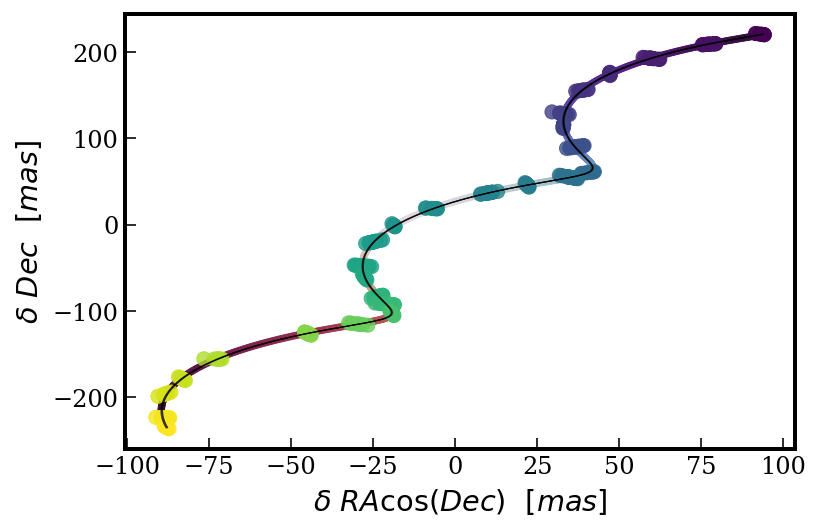

In [11]:
# optionally plot tracks
plotts=np.linspace(ts[0],ts[-1],1000)
cs=mpl.cm.twilight_shifted(np.interp(plotts,[plotts[0],plotts[-1]],[0,1]))

plotRacs,plotDecs=astromet.track(plotts,params)

ax=plt.gca()
fitparams=astromet.params()
for i in range(16):
    fitparams.ra=params.ra
    fitparams.dec=params.dec
    fitparams.drac=results['drac']+np.random.randn()*results['drac_error']
    fitparams.ddec=results['ddec']+np.random.randn()*results['ddec_error']
    fitparams.pmrac=results['pmrac']+np.random.randn()*results['pmrac_error']
    fitparams.pmdec=results['pmdec']+np.random.randn()*results['pmdec_error']
    fitparams.parallax=results['parallax']+np.random.randn()*results['parallax_error']

    fitRacs,fitDecs=astromet.track(plotts,fitparams)
    ax.plot(fitRacs,fitDecs,c='k',alpha=0.2,lw=0.5)
ax.scatter(plotRacs,plotDecs,c=cs,s=10,alpha=0.8)
plt.scatter(rac_obs, dec_obs, c=t_obs,s=50,alpha=0.8)
ax.set_xlabel(r'$\delta \ RA \cos(Dec) \ \ [mas]$')
ax.set_ylabel(r'$\delta \ Dec \ \ [mas]$')

plt.show()

### UWE~1 and astrometric_excess_noise is small (as expected without binary motion)

# Binary source

In [12]:
# System astrometry parameters
params=astromet.params()
params.ra=360*np.random.rand()
params.dec=np.arcsin(-1+2*np.random.rand())*180/np.pi
params.parallax=10*np.power(np.random.rand(),-1/3) # all within 100 pc
params.pmrac=params.parallax*np.random.normal(scale=6.67)
params.pmdec=params.parallax*np.random.normal(scale=6.67)

mag=np.random.rand()*6+10

c=Source(params.ra,params.dec,unit='deg')
sl=dr3_sl(c, return_times=True, return_angles=True)
ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
sort=np.argsort(ts)
ts=np.double(ts[sort])
phis=np.double(np.squeeze(np.hstack(sl['angles']))[sort])

params.period=10**(-1.5+3*np.random.rand()) # periods between 0.03 and 30 years
params.l=np.random.rand() # uniform light ratio
params.q=4*np.random.rand()**2 # mass ratios between 0 and 4 (half less than 1)
params.a=10*np.random.rand()**2
params.e=np.random.rand()
params.vtheta=np.arccos(-1+2*np.random.rand())
params.vphi=2*np.pi*np.random.rand()
params.vomega=2*np.pi*np.random.rand()
orbitalPhase=np.random.rand() # fraction of an orbit completed at t=0
params.tperi=params.period*orbitalPhase

In [13]:
drac_track, ddec_track=astromet.track(ts,params)

In [14]:
x_err = astromet.sigma_ast(mag)
t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.mock_obs(ts,phis,drac_track,ddec_track,err=x_err)

In [15]:
params.ra, params.dec, params.parallax, params.pmrac, params.pmdec

(303.7341173658222,
 36.10426302485122,
 13.231755204615268,
 -13.13661393612801,
 89.18351063374384)

In [16]:
# 'pmra' in gaia data is pmra*cos(dec) 
results=astromet.fit(t_obs,x_obs,phi_obs,x_err,params.ra,params.dec)
gaia_output=astromet.gaia_results(results)
gaia_output

{'astrometric_matched_transits': 53,
 'visibility_periods_used': 26,
 'astrometric_n_obs_al': 477,
 'astrometric_params_solved': 31,
 'ra': 303.73412369731085,
 'ra_error': 0.050640361995994886,
 'dec': 36.10426273796234,
 'dec_error': 0.054101192074820816,
 'ra_dec_corr': -0.11582672444250443,
 'parallax': 14.008541534776336,
 'parallax_error': 0.06648659084007778,
 'ra_parallax_corr': 0.09582718306974791,
 'dec_parallax_corr': -0.19973475700388052,
 'pmra': -13.457478853423105,
 'pmra_error': 0.0660670900246416,
 'ra_pmra_corr': -0.1817456553391263,
 'dec_pmra_corr': -0.04704569758771091,
 'parallax_pmra_corr': -0.0058458173206784175,
 'pmdec': 88.98207166895843,
 'pmdec_error': 0.06760254822927547,
 'ra_pmdec_corr': -0.032225016789323435,
 'dec_pmdec_corr': -0.11625619925008403,
 'parallax_pmdec_corr': 0.1358344039813764,
 'pmra_pmdec_corr': -0.10383672174947334,
 'astrometric_excess_noise': 0.6855999762535192,
 'astrometric_chi2_al': 2182.970976286488,
 'astrometric_n_good_obs_al':

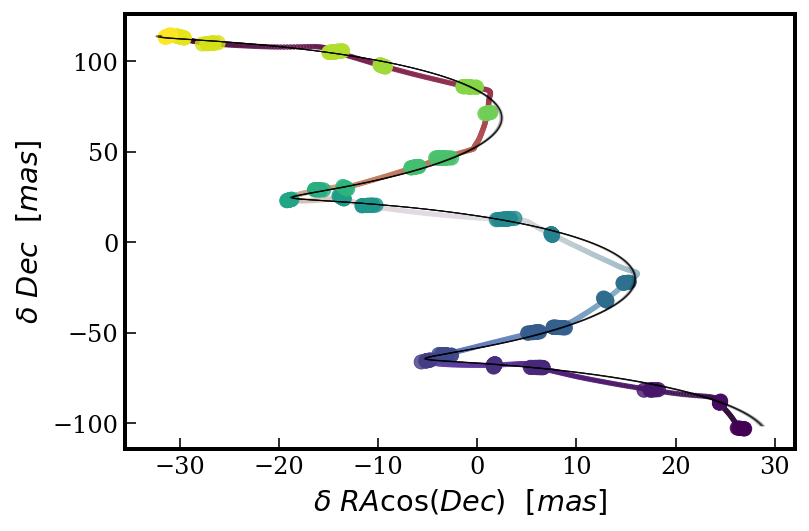

In [17]:
# optionally plot tracks
plotts=np.linspace(ts[0],ts[-1],1000)
cs=mpl.cm.twilight_shifted(np.interp(plotts,[plotts[0],plotts[-1]],[0,1]))

plotRacs,plotDecs=astromet.track(plotts,params)

ax=plt.gca()
fitparams=astromet.params()
for i in range(16):
    fitparams.ra=params.ra
    fitparams.dec=params.dec
    fitparams.drac=results['drac']+np.random.randn()*results['drac_error']
    fitparams.ddec=results['ddec']+np.random.randn()*results['ddec_error']
    fitparams.pmrac=results['pmrac']+np.random.randn()*results['pmrac_error']
    fitparams.pmdec=results['pmdec']+np.random.randn()*results['pmdec_error']
    fitparams.parallax=results['parallax']+np.random.randn()*results['parallax_error']

    fitRacs,fitDecs=astromet.track(plotts,fitparams)
    ax.plot(fitRacs,fitDecs,c='k',alpha=0.2,lw=0.5)
ax.scatter(plotRacs,plotDecs,c=cs,s=5,alpha=0.8)
plt.scatter(rac_obs, dec_obs, c=t_obs,s=50,alpha=0.8)
ax.set_xlabel(r'$\delta \ RA \cos(Dec) \ \ [mas]$')
ax.set_ylabel(r'$\delta \ Dec \ \ [mas]$')

plt.show()

### UWE is bigger and astrometric_excess_noise>0!